## Session 3: Execution of real quantum circuits on IBM's computers

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, EstimatorV2
from qiskit.quantum_info import SparsePauliOp, Operator

# Other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In the lab session we used premium accounts to fast forward over the long queue list of IBM's quantum machines. However at home we can use our free accounts to schedule calculations.

In [2]:
# Recover previous session information
df = pd.read_csv('session.csv')

# Loading account
service = QiskitRuntimeService(channel='ibm_quantum', token=df.token[0]) 

# Simulation machine
backend_S = AerSimulator()
# In the lab we used backend_S = service.backend('ibmq_qasm_simulator'), 
# however cloud simulators have been deprecated and will be removed on 15 May 2024

In [ ]:
# Quantum machine
backend_Q = service.least_busy(operational=True, simulator=False, min_num_qubits=20)

# Save backend
df.backend_Q = backend_Q.name
df.to_csv('session.txt', index=False)

In [3]:
backend_Q = service.get_backend(df.backend_Q[0]) 
backend_Q.status()

In [4]:
# Maximum execution time in seconds
my_options = {'max_execution_time': 30}

# Classical and quantum estimators
estimator_S = EstimatorV2(backend=backend_S)
estimator_Q = EstimatorV2(backend=backend_Q, options=my_options)

# Classical and quantum samplers
sampler_S = SamplerV2(backend=backend_S)
sampler_Q = SamplerV2(backend=backend_Q, options=my_options)

### **Random numbers**
The generation of random numbers using a classical simulator of a quantum machine was conducted during the second session. Now, let's generate "true random numbers"! To achieve this, we define a 3-qubit circuit that prepares each of them in the superposition $\tfrac{1}{\sqrt2}(|0\rangle+|1\rangle)$ and measures them in the computational basis ${|0\rangle,|1\rangle}$. This setup ensures that the measurement outcomes will be 0 or 1 with equal probabilities of 0.5.
#### <font color=teal> **Question 1**: Study the definition of the circuit with care </font>

**Answer:** It creates a barrier of Hadamard gates, which prepares each qubit in an equal superposition of $|0\rangle$ and $|1\rangle$. The circuit assigns three qubits to each random number to be generated, meaning the random numbers range between $0$ and $7$.

In [100]:
# How many random numbers will be produced in a single shot:
Nnumbers = 30  # Must be smaller than [127 qubits/3]=42
# Prepare the input circuit
QRNG = QuantumCircuit(3*Nnumbers) # Three qubits per number
QRNG.h(range(3*Nnumbers)) # Apply Hadamard gate to each of the qubits
QRNG.measure_all() # Measure all qubits
QRNG = transpile(QRNG, backend=backend_Q) # Adapt circuit to architecture of quantum machine

In [34]:
# Execute the circuit directly on a quantum computer
job_qrng = sampler_Q.run([QRNG], shots=1)

# Save job identification code for later
df.qrng_id = job_qrng.job_id()
df.to_csv('session.txt', index=False)

c:\Users\zapat\Escritorio\CODE\PIE_Compu_Cuantica\venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 649.5556236231932 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [81]:
# The following cell retrieves information about the job
job_qrng = service.job(df.qrng_id[0])
job_qrng.status() 

<JobStatus.DONE: 'job has successfully run'>

In [82]:
# The next statement can put your session on hold until the job runs and returns
result_qrng = job_qrng.result()

#### <font color=teal> **Question 2**:  Comment on your results </font>

**Answer:** We obtained the following result from the IBM Quantum computer run in the lab with UCM tokens:

``[{236732400872330227231122054: 1.0}]``

After depuration we obtain the following list of numbers

``[6, 0, 2, 1, 6, 4, 4, 5, 2, 2, 3, 3, 4, 2, 2, 3, 2, 1, 2, 5, 2, 2, 2, 0, 2, 2, 7, 1, 4, 1]``

that we can plot in a *histogram*.

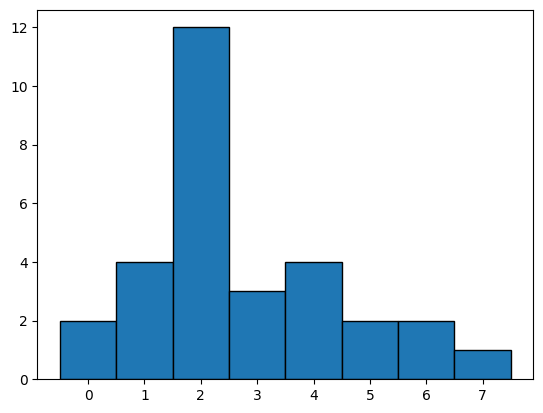

In [7]:
RandomNumbers = [6, 0, 2, 1, 6, 4, 4, 5, 2, 2, 3, 3, 4, 2, 2, 3, 2, 1, 2, 5, 2, 2, 2, 0, 2, 2, 7, 1, 4, 1]
plt.hist(RandomNumbers, bins=range(9), align='left', edgecolor='black', linewidth=1)
plt.show()

We can likewise retrieve our own results run at home.

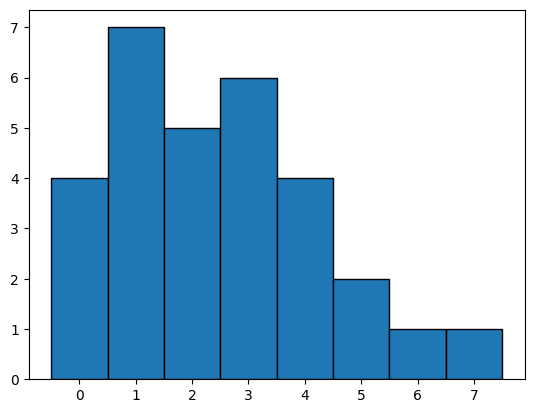

In [134]:
bits, = result_qrng[0].data.meas.get_counts()
numbers = [bits[i:i+3] for i in range(0, 3*Nnumbers, 3)]
decimal_numbers = [int(n, 2) for n in numbers]
plt.hist(decimal_numbers, bins=range(9), align='left', edgecolor='black', linewidth=1)
plt.show()

### **Deutsch's algorithm**

To encode the action of a Boolean fuction, the Deutsch's algorithm uses the following operation over two qubits

$$
|x\rangle|y\rangle\to |x\rangle|y\oplus f(x)\rangle
$$

where $\oplus$ denotes the binary addition (i.e. the addition mod. 2).

#### <font color=teal> **Homework 1** (to do later after the lab on pen and paper): <br>  Prove that this is a unitary operation. </font>

**Answer:** It is clear that the quantum oracle preserves the norm of the basis vectors and is invertible, therefore it is unitary. If we take $(x,y)\in\{0,1\}^2, f(x)\in\{0,1\}$, we have that $y\oplus f(x)\in\{0,1\}$ &mdash; in other words, $|x\rangle|y\oplus f(x)\rangle$ is a valid (basis) ket of the 4D Hilbert space. Thus:

$$
(\langle x|\langle y|)U_f^\dagger U_f(|x\rangle|y\rangle) =(\langle x|\langle y\oplus f(x)|)(|x\rangle|y\oplus f(x)\rangle) = \langle x|x\rangle\langle y\oplus f(x)|y\oplus f(x)\rangle = 1
$$

Alternatively, given there exist a finite number of Boolean functions, we can calculate the oracle matrix for each $f$. If we place the control qubit $|x\rangle$ first, as we'll later do in the circuits (so $|y,x\rangle\rightarrow|y\oplus f(x), x\rangle$), the representations of $U_f$ are

$$
\begin{align}
f(x)&=0:\quad
U_f = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix},
&
f(x)&=1:\quad
U_f = \begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix}
\end{align}
$$

$$
\begin{align}
f(x)&=x: \quad
U_f = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix},
&
f(x)&=\neg x:\quad
U_f = \begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
\end{align}
$$

These matrices all represent permutations, which are unitary operations.

#### <font color=teal> **Question 2**: Complete the following cells to create quantum circuits for Oracle_f that decides whether $f$ is (or not) constant using the classical method with two evaluations </font>

**Answer:** To evaluate $f$ using the oracle we can measure the rightmost qubit in the following two states:

$$
U_f|0\rangle|0\rangle = |0\rangle|f(0)\rangle
$$

$$
U_f|1\rangle|0\rangle = |1\rangle|f(1)\rangle
$$

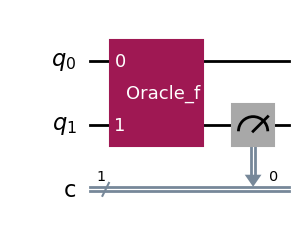

In [9]:
Oracle_f = Operator([[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,0,1]])
Oracle_g = Operator([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])

# First evaluation
Check_f0 = QuantumCircuit(2,1)
Check_f0.unitary(Oracle_f, [0, 1], label='Oracle_f')
Check_f0.measure(1, 0)
Check_f0.draw(output='mpl')

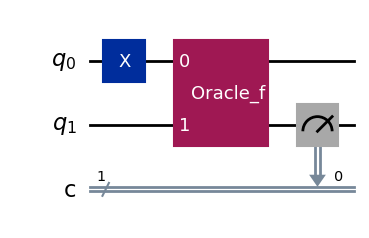

In [123]:
# Second evaluation
Check_f1 = QuantumCircuit(2,1)
Check_f1.x(0)
Check_f1.unitary(Oracle_f, [0, 1], label='Oracle_f')
Check_f1.measure(1,0)
Check_f1.draw(output='mpl')

In [183]:
# Run both evaluations
job_clf = sampler_S.run([Check_f0, Check_f1], shots=1)
result_clf = job_clf.result()

#### <font color=teal> **Question 3**: By printing "result_clf.quasi_dists", explain why the following cell gives the calculated result for $f(0)$ and $f(1)$. </font>

**Answer:** The function $f(x)$ appears to be $\neg x$, and therefore a balanced function. Indeed, if we compare the `Oracle_f` with the matrix we calculated above for $f(x)=\neg x$, they coincide. 

N.B.: For my calculations at home I used the `SamplerV2` class which has slightly different methods for retrieving results as compared to `Sampler`.

In [184]:
# Print the measurement results
print(f'f(0) = {int(*result_clf[0].data.c.get_counts())}')
print(f'f(1) = {int(*result_clf[1].data.c.get_counts())}')

f(0) = 1
f(1) = 0


#### <font color=teal> **Question 4**: Complete the following cells to create quantum circuits for Oracle_g that solve the problem of whether $g$ is constant using the classical method of two evaluations </font>

**Answer:** We may repeat the previous process. We find that $g(x)=1$, therefore $g$ is a constant function.

In [186]:
# First evaluation
Check_g0 = QuantumCircuit(2,1)
Check_g0.unitary(Oracle_g, [0, 1], label='Oracle_g')
Check_g0.measure(1, 0)

# Second evaluation
Check_g1 = QuantumCircuit(2,1)
Check_g1.x(0)
Check_g1.unitary(Oracle_g, [0, 1], label='Oracle_g')
Check_g1.measure(1,0)

# Run both evaluations
job_clg = sampler_S.run([Check_g0, Check_g1], shots=1)
result_clg = job_clg.result()

# Print the measurement results
print(f'g(0) = {int(*result_clg[0].data.c.get_counts())}')
print(f'g(1) = {int(*result_clg[1].data.c.get_counts())}')

g(0) = 1
g(1) = 1


The idea of Deutsch's algorithm is based on the use of quantum superposition to attempt a simultaneous evaluation and comparison of $f(0)$ and $f(1)$ with a single action of the quantum oracle.

If $f(0)=f(1)$,

$$
U_f|+\rangle|-\rangle=\frac{1}{2}\big[|0\rangle|f(0)\rangle-|0\rangle|1\oplus f(0)\rangle+|1\rangle|f(0)\rangle-|1\rangle|1\oplus f(0)\rangle\big]$$
$$=\frac{1}{2}\big[\big(|0\rangle+|1\rangle\big)|f(0)\rangle-\big(|0\rangle+|1\rangle\big)|1\oplus f(0)\rangle\big]=|+\rangle \left[\frac{|f(0)\rangle-|1\oplus f(0)\rangle}{\sqrt{2}}\right]
$$

#### <font color=teal> **Homework question 5**: Prove (after the lab, on pen and paper): </font>
<font color=teal> the alternative case, that
if $f(0)\neq f(1)$, the final state becomes: </font>
    
$$
|-\rangle \left[\frac{|f(0)\rangle-|f(1)\rangle}{\sqrt{2}}\right].
$$

**Answer:** If $f(0)\neq f(1)$, then $f(0)\oplus 1=f(1)$ and $f(1)\oplus 1=f(0)$, therefore
$$
|+\rangle|-\rangle=\frac{1}{2}\big(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle\big)\to $$
$$\frac{1}{2}\big[|0\rangle|f(0)\rangle-|0\rangle|1\oplus f(0)\rangle+|1\rangle|f(1)\rangle-|1\rangle|1\oplus f(1)\rangle\big] = $$
$$ = \frac{1}{2}\big[|0\rangle|f(0)\rangle-|0\rangle|f(1)\rangle+|1\rangle|f(1)\rangle-|1\rangle|f(0)\rangle\big] = $$
$$ = \frac{1}{2}\big[|0\rangle-|1\rangle\big]\big[|f(0)\rangle-|f(1)\rangle\big] =|-\rangle \left[\frac{|f(0)\rangle-|f(1)\rangle}{\sqrt{2}}\right]$$


After applying the oracle to $|+\rangle|-\rangle$, we may apply a Hadamard gate to the leftmost qubit and then measure it. This way we obtain $0$ if $f$ is constant and $1$ if $f$ is balanced.

#### <font color=teal> **Question 6**: Define a quantum circuit to implement Deutsch's algorithm with the function $f$ and another with the function $g$ </font>

**Answer:**

For the function $f$:

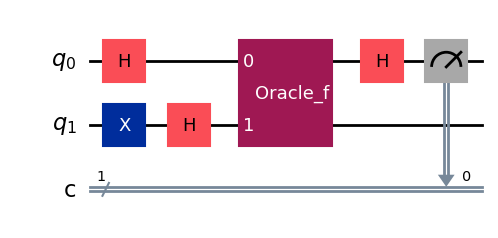

In [10]:
deutsch_f = QuantumCircuit(2,1)
deutsch_f.x(1)
deutsch_f.h([0, 1])
deutsch_f.unitary(Oracle_f, [0, 1], label='Oracle_f')
deutsch_f.h(0)
deutsch_f.measure(0,0)
deutsch_f.draw(output='mpl')

And for the function $g$ we just change the oracle:

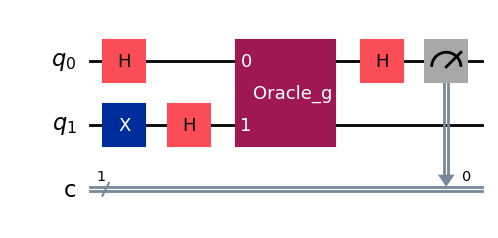

In [11]:
deutsch_g = QuantumCircuit(2,1)
deutsch_g.x(1)
deutsch_g.h([0, 1])
deutsch_g.unitary(Oracle_g, [0, 1], label='Oracle_g')
deutsch_g.h(0)
deutsch_g.measure(0,0)
deutsch_g.draw(output='mpl')

In [26]:
# Execute the circuit
job_Deutsch_S = sampler_S.run([deutsch_f, deutsch_g], shots=1)
result_Deutsch_S = job_Deutsch_S.result()

# Print the measurement results
if int(*result_Deutsch_S[0].data.c.get_counts()) == 0:
    print('f is constant')
else:
    print('f is balanced')
if int(*result_Deutsch_S[1].data.c.get_counts()) == 0:
    print('g is constant')
else:
    print('g is balanced')

f is balanced
g is constant


#### <font color=teal> **Question 7**: Does the result of your quantum computation using Deutsch's algorithm agree with the previous classical result?

**Answer:** The classical result is that $f$ is balanced and $g$ is constant. After applying Deutsch's algorithm to both functions, we obtained the same result &mdash; that is, that $f$ is balanced and $g$ is constant. Our run in the lab with UCM tokens yielded the same result.

In [13]:
# Transpile circuits to backend architecture
deutsch_f_t = transpile(deutsch_f, backend=backend_Q)
deutsch_g_t = transpile(deutsch_g, backend=backend_Q)

# Execute the circuit
job_Deutsch_Q = sampler_Q.run([deutsch_f_t, deutsch_g_t], shots=3)

# Save job identification code for later
df.deutsch_id = job_Deutsch_Q.job_id()
df.to_csv('session.csv', index=False)

c:\Users\zapat\Escritorio\CODE\PIE_Compu_Cuantica\venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 649.5556236231932 quantum seconds, but you only have 588 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [14]:
# The following cell retrieves information about the job
job_Deutsch_Q = service.job(df.deutsch_id[0])
job_Deutsch_Q.status() 

<JobStatus.QUEUED: 'job is queued'>

In [6]:
# The next statement can put your session on hold until the job runs and returns
result_Deutsch_Q = job_Deutsch_Q.result()
ans_f = result_Deutsch_Q[0].data.c.get_counts()
ans_g = result_Deutsch_Q[1].data.c.get_counts()

# Print the measurement results
if max(ans_f, key=ans_f.get) == 0:
    print('f is constant')
else:
    print('f is balanced')
if max(ans_g, key=ans_g.get) == 0:
    print('g is constant')
else:
    print('g is balanced')

f is balanced
g is balanced


### **Experimental measurement of a Bell inequality <br> (CHSH combination of correlators)**

If $\{A_1, A_2\}$ and $\{B_1,B_2\}$ are two pairs of observables (with dichotomic/binary outcome) of two spatially separated systems, the expected values of their products $\langle A_i B_j \rangle$ according to any local hidden variable model (that is, an attempt at trying to explain away quantum features with additional classical mechanics variables) satisfy the classical CHSH inequality

$$
|\langle A_1 B_1\rangle +\langle A_1 B_2\rangle + \langle A_2 B_1\rangle - \langle A_2 B_2\rangle|\leq 2 .
$$

Quantum theory, on the contrary, predicts that this inequality is violated for a suitable choice of observables, obtaining the maximum violation, in the case of two qubits, when

$$
A_1=X,\quad A_2=Y, \quad B_1=\frac{-(X+Y)}{\sqrt{2}}, \quad B_2=\frac{-(X-Y)}{\sqrt{2}}
$$
or rotationally equivalent configurations. Here $X$ and $Y$ denote the $\sigma_x$ and $\sigma_y$ Pauli matrices.

#### <font color=teal> **Question 2**: Using this command, define the four product observables that appear in the CHSH inequality: $A_1B_1$, $A_2B_1$, $A_1B_2$, and $A_2B_2$: </font>

**Answer:**

In [28]:
# Define pairs of observables for maximum violation of the CHSH innequality
A1B1aux = SparsePauliOp.from_list([('XX', -1/np.sqrt(2)), ('XY', -1/np.sqrt(2))])
A1B2aux = SparsePauliOp.from_list([('XX', -1/np.sqrt(2)), ('XY', +1/np.sqrt(2))])
A2B1aux = SparsePauliOp.from_list([('YX', -1/np.sqrt(2)), ('YY', -1/np.sqrt(2))])
A2B2aux = SparsePauliOp.from_list([('YX', -1/np.sqrt(2)), ('YY', +1/np.sqrt(2))])
Obsaux = [A1B1aux, A1B2aux, A2B1aux, A2B2aux]
n_remaining_qubits = 125
I125 = SparsePauliOp('I' * n_remaining_qubits)
A1B1 = A1B1aux.tensor(I125)
A1B2 = A1B2aux.tensor(I125)
A2B1 = A2B1aux.tensor(I125)
A2B2 = A2B2aux.tensor(I125)
Obs = [A1B1, A1B2, A2B1, A2B2]

#### <font color=teal> **Question 1**:  Define a circuit that prepares the "singlet state" of two qubits $|\Psi^-\rangle=\tfrac{1}{\sqrt2}(|01\rangle-|10\rangle)$.</font>

**Answer:** The following circuit specifically prepares the state $\tfrac{i}{\sqrt2}(|01\rangle-|10\rangle)$, which is physically equivalent to the requested state.

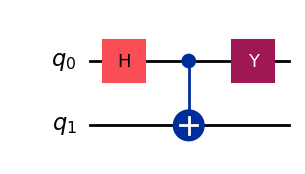

In [29]:
# Prepare the input circuit:
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0) # Hadamard on the first qubit
chsh_circuit.cx(0,1) # NOT controlled to the first qubit
chsh_circuit.y([0]) # Y-Pauli gate to the first qubit
chsh_circuit.draw(output='mpl')

#### <font color=teal> **Question 3**: Calculate the simulated value obtained for the CHSH inequality jointly with its error </font>

**Answer:** The code we ran in the lab with UCM tokens yielded:

``The simulated result is 2.81824 + 0.04:``

``does it exceed 2 with sufficient statistical certainty?``


In [30]:
# Execute the circuit
job_CHSH_S = estimator_S.run([(chsh_circuit, Obsaux)])
result_S = job_CHSH_S.result()

# Statistical results
values_S = result_S[0].data.evs
Standard_errors_S = result_S[0].data.stds

# Print simulated expectation values
print('Simulated expectation values for the four correlators:')
print([f'{v:.3f} ± {s:.3f}' for v, s in zip(values_S, Standard_errors_S)])

Simulated expectation values for the four correlators:
['0.708 ± 0.011', '0.706 ± 0.011', '0.689 ± 0.011', '-0.725 ± 0.011']


In [31]:
# CHSH value
CHSH_mean_S = abs(values_S[0] + values_S[1] + values_S[2] - values_S[3])
CHSH_uncertainty_S = np.sum(Standard_errors_S)
print(f'''
The simulated result is {CHSH_mean_S:.3f} ± {CHSH_uncertainty_S:.3f}:
does it exceed 2 with sufficient statistical certainty?
''')


The simulated result is 2.828 ± 0.044:
does it exceed 2 with sufficient statistical certainty?



####  <font color=teal> **Question 4**: Compute, with a hand calculator or simple python commands, the experimental value obtained for the CHSH inequality jointly with its error from the quantum data obtained. </font>

**Answer:** The code we ran in the lab with UCM tokens yielded:

``The simulated result is 2.60215 + 0.41467:``

``does it exceed 2 with sufficient statistical certainty?``

In [266]:
# Transpile circuit to backend architecture
chsh_circuit_t = transpile(chsh_circuit, backend=backend_Q)

# Execute the circuit
job_CHSH_Q = estimator_Q.run([(chsh_circuit_t, Obs)])

# Save job identification code for later
df.chsh_id = job_CHSH_Q.job_id()
df.to_csv('session.csv', index=False)

c:\Users\zapat\Escritorio\CODE\PIE_Compu_Cuantica\venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 1272.6590615597552 quantum seconds, but you only have 598 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [32]:
# The following cell retrieves information about the job
job_CHSH_Q = service.job(df.chsh_id[0])
job_CHSH_Q.status() 

<JobStatus.DONE: 'job has successfully run'>

In [25]:
# The next statement can put your session on hold until the job runs and returns
result_Q = job_CHSH_Q.result()

# Statistical results
values_Q = result_Q[0].data.evs
Standard_errors_Q = result_Q[0].data.stds

# Print simulated expectation values
print('Simulated expectation values for the four correlators:')
print([f'{v:.3f} ± {s:.3f}' for v, s in zip(values_Q, Standard_errors_Q)])

Simulated expectation values for the four correlators:
['-0.028 ± 0.026', '-0.028 ± 0.026', '0.054 ± 0.034', '0.026 ± 0.034']


In [22]:
# CHSH value
values_Q = result_Q[0].data.evs
Standard_errors_Q = result_Q[0].data.stds
CHSH_mean_Q = abs(values_Q[0] + values_Q[1] + values_Q[2] - values_Q[3])
CHSH_uncertainty_Q = np.sum(Standard_errors_Q)
print(f'''
The simulated result is {CHSH_mean_Q:.3f} ± {CHSH_uncertainty_Q:.3f}:
does it exceed 2 with sufficient statistical certainty?
''')


The simulated result is 0.029 ± 0.119:
does it exceed 2 with sufficient statistical certainty?

